In [1]:
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, roc_curve

import matplotlib.pyplot as plt
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cuda')

In [2]:
train_path = "../raw_data/UNSW_NB15_training-set.csv"
test_path  = "../raw_data/UNSW_NB15_testing-set.csv"

assert os.path.exists(train_path), "Arquivo de treino não encontrado"
assert os.path.exists(test_path), "Arquivo de teste não encontrado"

train_df = pd.read_csv(train_path)
test_df  = pd.read_csv(test_path)

train_df.head()


,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.121478,tcp,-,FIN,6,4,258,172,74.087490,...,1,1,0,0,0,1,1,0,Normal,0
1,2,0.649902,tcp,-,FIN,14,38,734,42014,78.473372,...,1,2,0,0,0,1,6,0,Normal,0
2,3,1.623129,tcp,-,FIN,8,16,364,13186,14.170161,...,1,3,0,0,0,2,6,0,Normal,0
3,4,1.681642,tcp,ftp,FIN,12,12,628,770,13.677108,...,1,3,1,1,0,2,1,0,Normal,0
4,5,0.449454,tcp,-,FIN,10,6,534,268,33.373826,...,1,40,0,0,0,2,39,0,Normal,0


In [3]:
drop_cols = ["label"]
if "attack_cat" in train_df.columns:
    drop_cols.append("attack_cat")

X_train = train_df.drop(columns=drop_cols)
y_train = train_df["label"].astype(int).clip(0, 1)

X_test = test_df.drop(columns=drop_cols)
y_test = test_df["label"].astype(int).clip(0, 1)


In [4]:
cat_cols = X_train.select_dtypes(include=["object"]).columns.tolist()
print("Colunas categóricas removidas:", cat_cols)

X_train = X_train.drop(columns=cat_cols)
X_test  = X_test.drop(columns=cat_cols)

X_train.shape, X_test.shape


Colunas categóricas removidas: ['proto', 'service', 'state']


((175341, 40), (82332, 40))

In [5]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)


In [6]:
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train.values, dtype=torch.float32)

X_test_t  = torch.tensor(X_test, dtype=torch.float32)
y_test_t  = torch.tensor(y_test.values, dtype=torch.float32)


In [7]:
train_loader = DataLoader(
    TensorDataset(X_train_t, y_train_t),
    batch_size=64,
    shuffle=True
)

test_loader = DataLoader(
    TensorDataset(X_test_t, y_test_t),
    batch_size=64,
    shuffle=False
)


In [8]:
class MLP(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.net(x)


model = MLP(X_train.shape[1]).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

model


MLP(
  (net): Sequential(
    (0): Linear(in_features=40, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=1, bias=True)
  )
)

In [9]:
epochs = 10

for epoch in range(epochs):
    model.train()
    total_loss = 0.0

    for xb, yb in train_loader:
        xb = xb.to(device)
        yb = yb.to(device)

        optimizer.zero_grad()
        logits = model(xb).squeeze()
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs} - Loss: {total_loss/len(train_loader):.4f}")


Epoch 1/10 - Loss: 0.1154
Epoch 2/10 - Loss: 0.0751
Epoch 3/10 - Loss: 0.0643
Epoch 4/10 - Loss: 0.0601
Epoch 5/10 - Loss: 0.0569
Epoch 6/10 - Loss: 0.0541
Epoch 7/10 - Loss: 0.0522
Epoch 8/10 - Loss: 0.0505
Epoch 9/10 - Loss: 0.0497
Epoch 10/10 - Loss: 0.0472


In [10]:
model.eval()

y_true = []
y_scores = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        logits = model(xb).squeeze()
        probs = torch.sigmoid(logits)

        y_scores.extend(probs.cpu().numpy().ravel())
        y_true.extend(yb.numpy())

y_true = np.array(y_true)
y_scores = np.array(y_scores)

print("ROC AUC:", roc_auc_score(y_true, y_scores))


ROC AUC: 0.6083627480498235


In [11]:
def detection_metrics(y_true, y_scores, threshold):
    y_pred = (y_scores >= threshold).astype(int)

    tp = ((y_pred == 1) & (y_true == 1)).sum()
    fp = ((y_pred == 1) & (y_true == 0)).sum()
    fn = ((y_pred == 0) & (y_true == 1)).sum()
    tn = ((y_pred == 0) & (y_true == 0)).sum()

    recall = tp / (tp + fn + 1e-8)
    precision = tp / (tp + fp + 1e-8)
    fpr = fp / (fp + tn + 1e-8)

    return recall, precision, fpr


In [12]:
thresholds = np.linspace(0.05, 0.95, 50)
records = []

for t in thresholds:
    recall, precision, fpr = detection_metrics(y_true, y_scores, t)
    records.append((t, recall, precision, fpr))

results = pd.DataFrame(
    records,
    columns=["threshold", "recall", "precision", "fpr"]
)

results.head()


,threshold,recall,precision,fpr
0,0.050000,0.432079,0.577277,0.387649
1,0.068367,0.428968,0.576263,0.386459
2,0.086735,0.426343,0.575585,0.385162
3,0.105102,0.424137,0.575125,0.383892
4,0.123469,0.422968,0.575433,0.382351


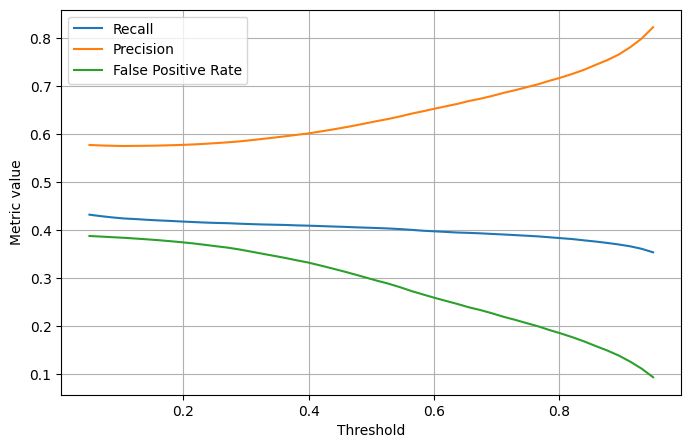

In [13]:
plt.figure(figsize=(8, 5))
plt.plot(results["threshold"], results["recall"], label="Recall")
plt.plot(results["threshold"], results["precision"], label="Precision")
plt.plot(results["threshold"], results["fpr"], label="False Positive Rate")

plt.xlabel("Threshold")
plt.ylabel("Metric value")
plt.legend()
plt.grid(True)
plt.show()


In [14]:
candidates = results[
    (results["recall"] >= 0.80) &
    (results["fpr"] <= 0.20)
]

candidates.sort_values(by="precision", ascending=False).head()


,threshold,recall,precision,fpr


In [15]:
threshold_star = 0.32  # exemplo

recall, precision, fpr = detection_metrics(
    y_true, y_scores, threshold_star
)

print(f"Threshold : {threshold_star:.2f}")
print(f"Recall    : {recall*100:.2f}%")
print(f"Precision : {precision*100:.2f}%")
print(f"FPR       : {fpr*100:.2f}%")


Threshold : 0.32
Recall    : 41.20%
Precision : 58.90%
FPR       : 35.23%
